In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


## Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler , StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


## Load your dataset

In [5]:
data = pd.read_csv('/home/mr-arthor/Desktop/Codes/CDAC_Project_Work/Topic_2/DataSet/powerconsumption.csv')


### Look at Dataset

In [6]:
data.sample(5)


,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
541,1/4/2017 18:10,14.57,72.30,0.079,7.030,7.050,43309.36709,27698.48024,25613.49398
13961,4/7/2017 22:50,14.17,83.90,0.071,0.095,0.197,35415.62971,18436.25255,24733.09091
31377,8/6/2017 21:30,28.59,73.10,4.904,0.066,0.119,43567.59156,34563.04118,37268.46395
11312,3/20/2017 13:20,15.55,63.24,0.082,524.800,342.600,34817.36170,21318.29268,16954.83871
10252,3/13/2017 4:40,8.76,86.70,0.090,0.044,0.148,23003.23404,13390.24390,14957.41935


#### Converting  'Datetime' column to datetime

In [7]:
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%m/%d/%Y %H:%M', dayfirst=True)


Set the 'Dates' column as the index

In [8]:
data.set_index('Datetime', inplace=True)


In [9]:
data['TotalPowerConsumption']= data['PowerConsumption_Zone1'] + data['PowerConsumption_Zone2'] + data['PowerConsumption_Zone3']


In [10]:
data= data.drop(['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'],axis=1)


## Checking for Missing values

In [11]:
data.isnull().sum()


Temperature              0
Humidity                 0
WindSpeed                0
GeneralDiffuseFlows      0
DiffuseFlows             0
TotalPowerConsumption    0
dtype: int64

## Checking for Outliers

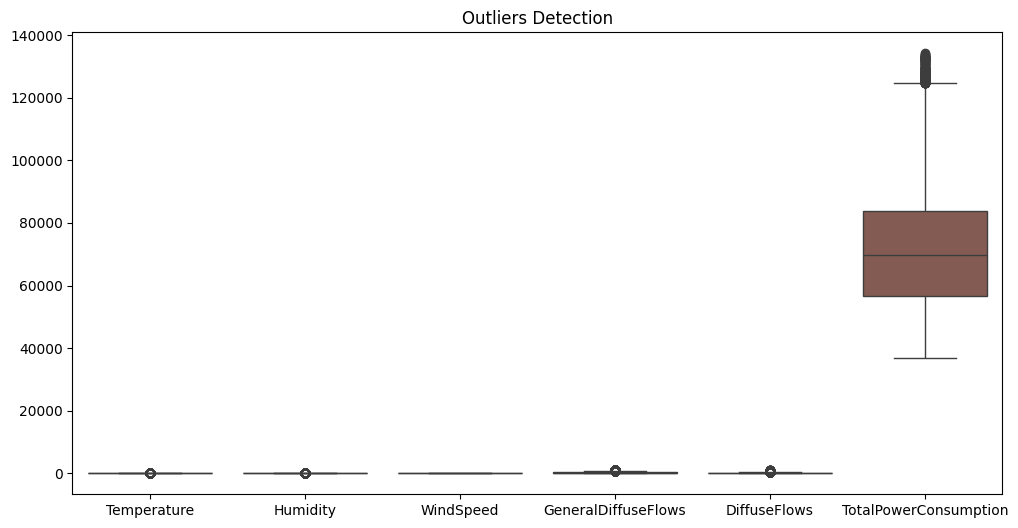

In [12]:
plt.figure(figsize=(12,6))
sns.boxplot(data)
plt.title('Outliers Detection')
plt.show()


Some Outliers found. Lets remove them

In [13]:
RS = RobustScaler()


In [14]:
x = data.drop(['TotalPowerConsumption'],axis=1)
y = data['TotalPowerConsumption']


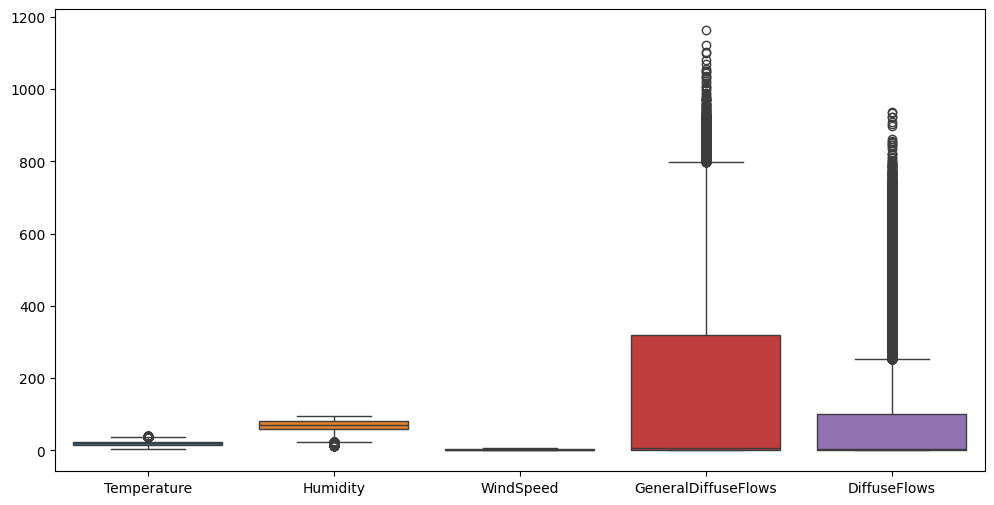

In [15]:
plt.figure(figsize=(12,6))
sns.boxplot(x)
plt.show()


In [16]:
scaled_x = RS.fit_transform(x)


In [17]:
x= pd.DataFrame(scaled_x, columns=x.columns)


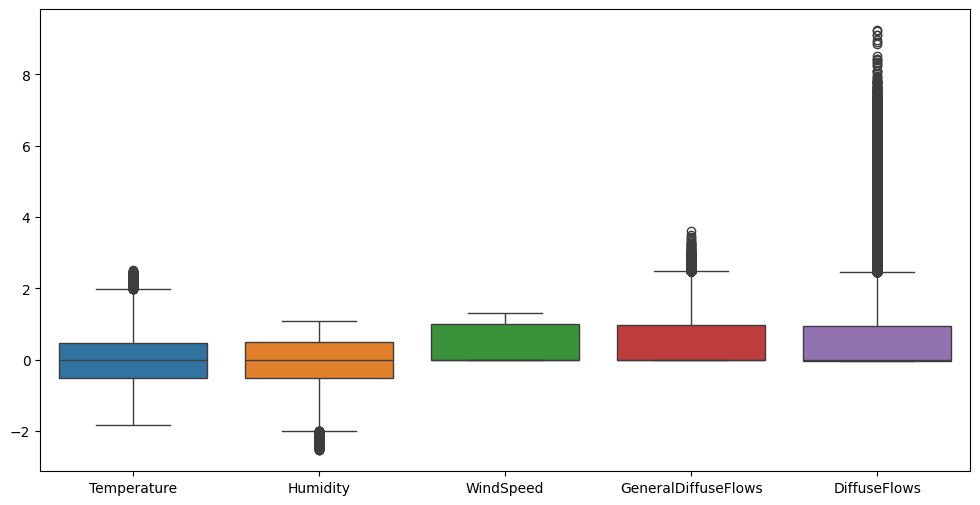

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(x)
plt.show()


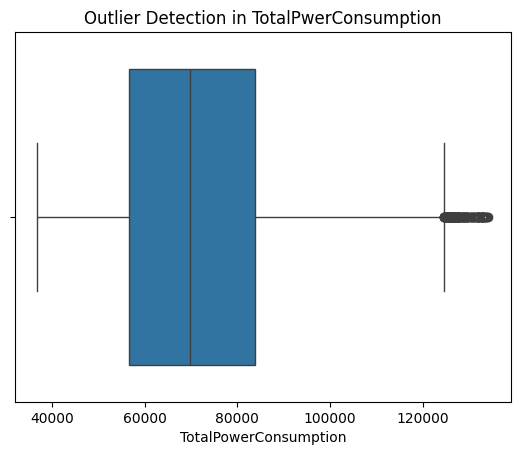

In [19]:
sns.boxplot(x='TotalPowerConsumption',data=data)
plt.title('Outlier Detection in TotalPwerConsumption')
plt.show()


In [20]:
Q1 = data['TotalPowerConsumption'].quantile(0.25)
Q3 = data['TotalPowerConsumption'].quantile(0.75)

IQR = Q3 - Q1

lowerbound = Q1 - (1.5 * IQR)
upperbound = Q3 + (1.5 * IQR)

data = data[(data.TotalPowerConsumption >= lowerbound) & (data.TotalPowerConsumption <= upperbound)]


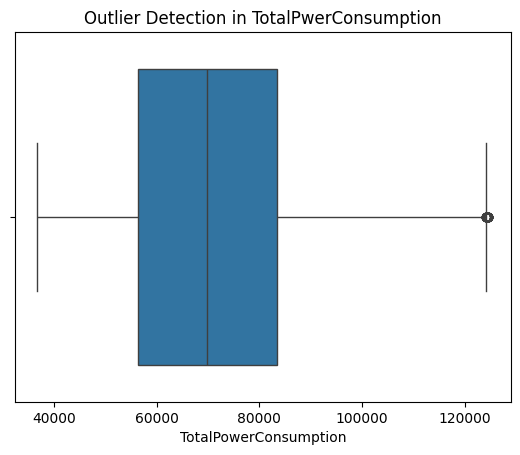

In [21]:
sns.boxplot(x='TotalPowerConsumption',data=data)
plt.title('Outlier Detection in TotalPwerConsumption')
plt.show()


## Checking and Fixing Data Distribution

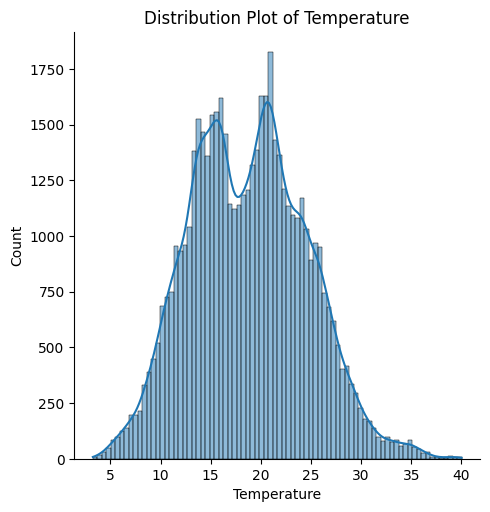

In [22]:
sns.displot(data['Temperature'], kde=True)
plt.title('Distribution Plot of Temperature')
plt.show()


In [23]:
data['Temperature'].skew()


0.19847847347894332

In [24]:
from scipy.stats import boxcox
data['Temperature'], lambda_boxcox = boxcox(data['Temperature'])


In [25]:
data['Temperature'].skew()


-0.028399651548740974

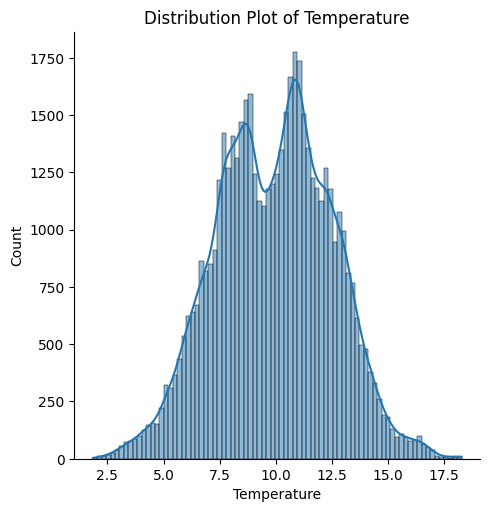

In [26]:
sns.displot(data['Temperature'], kde=True)
plt.title('Distribution Plot of Temperature')
plt.show()


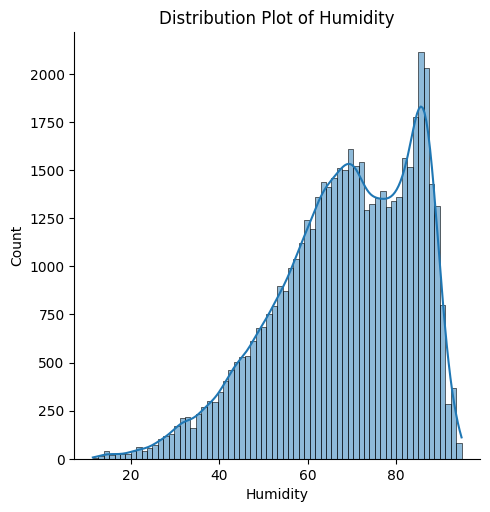

In [27]:
sns.displot(data['Humidity'], kde=True) 
plt.title('Distribution Plot of Humidity')
plt.show()


In [28]:
data['Humidity'].skew()


-0.6267255308810648

In [29]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
data['Humidity'] = pt.fit_transform(data[['Humidity']])


In [30]:
data['Humidity'].skew()


-0.16303592371905884

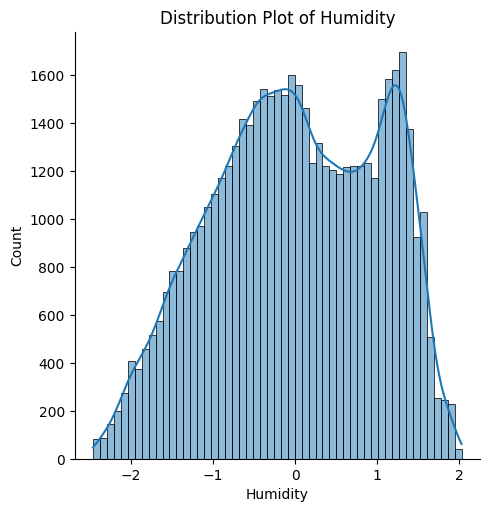

In [31]:
sns.displot(data['Humidity'], kde=True) 
plt.title('Distribution Plot of Humidity')
plt.show()


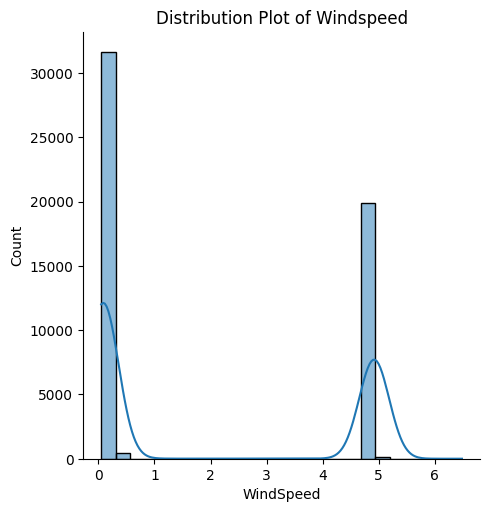

In [32]:
sns.displot(data['WindSpeed'], kde=True) 
plt.title('Distribution Plot of Windspeed')
plt.show()


In [33]:
data['WindSpeed'].skew()


0.4692908180744133

In [34]:
from scipy.stats import boxcox
data['WindSpeed'], lambda_boxcox = boxcox(data['WindSpeed'])


In [35]:
data['WindSpeed'].skew()


0.38736112281085533

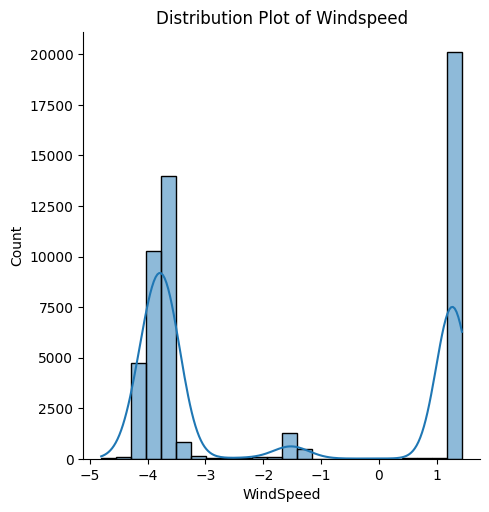

In [36]:
sns.displot(data['WindSpeed'], kde=True) 
plt.title('Distribution Plot of Windspeed')
plt.show()


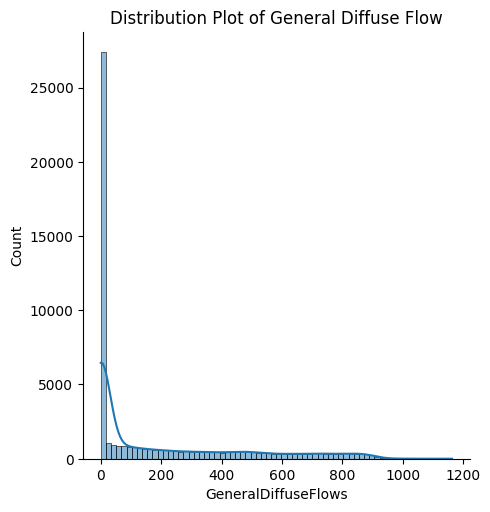

In [37]:
sns.displot(data['GeneralDiffuseFlows'], kde=True) 
plt.title('Distribution Plot of General Diffuse Flow')
plt.show()


In [38]:
data['GeneralDiffuseFlows'].skew()


1.3027028537291285

In [39]:
data['GeneralDiffuseFlows'], lambda_boxcox = boxcox(data['GeneralDiffuseFlows'])


In [40]:
data['GeneralDiffuseFlows'].skew()


0.03755922696595876

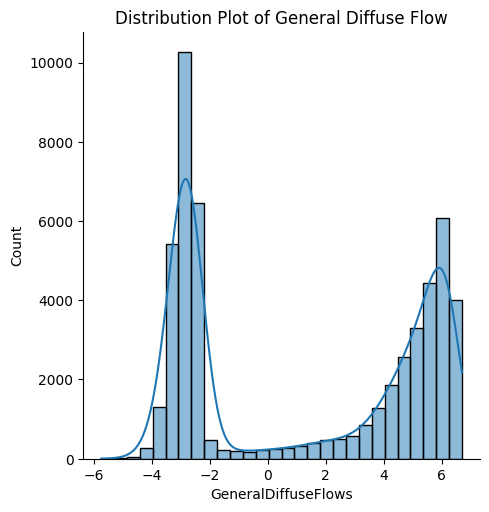

In [41]:
sns.displot(data['GeneralDiffuseFlows'], kde=True) 
plt.title('Distribution Plot of General Diffuse Flow')
plt.show()


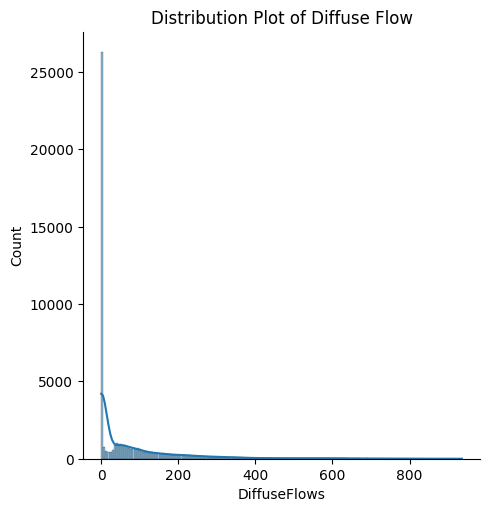

In [42]:
sns.displot(data['DiffuseFlows'], kde=True) 
plt.title('Distribution Plot of Diffuse Flow')
plt.show()


In [43]:
data['DiffuseFlows'].skew()


2.4524126239824557

In [44]:
data['DiffuseFlows'], lambda_boxcox = boxcox(data['DiffuseFlows'])


In [45]:
data['DiffuseFlows'].skew()


0.05059341906012308

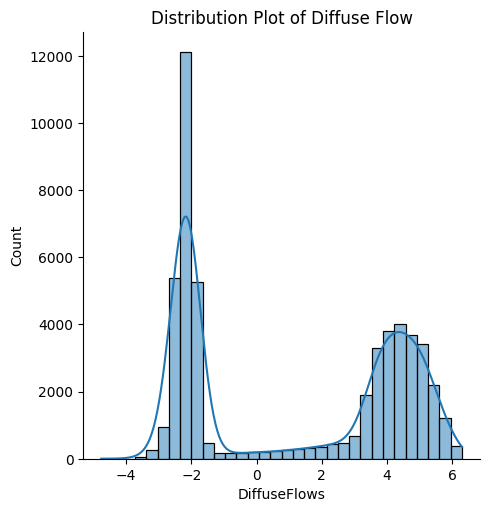

In [46]:
sns.displot(data['DiffuseFlows'], kde=True) 
plt.title('Distribution Plot of Diffuse Flow')
plt.show()


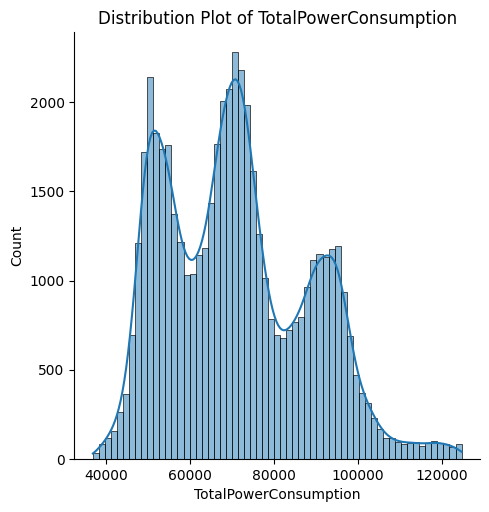

In [47]:
sns.displot(data['TotalPowerConsumption'], kde=True) 
plt.title('Distribution Plot of TotalPowerConsumption')
plt.show()


In [48]:
data['TotalPowerConsumption'].skew()


0.4640428873892331

In [49]:
data['TotalPowerConsumption'], lambda_boxcox = boxcox(data['TotalPowerConsumption'])


In [50]:
data['TotalPowerConsumption'].skew()


0.0024978685644179966

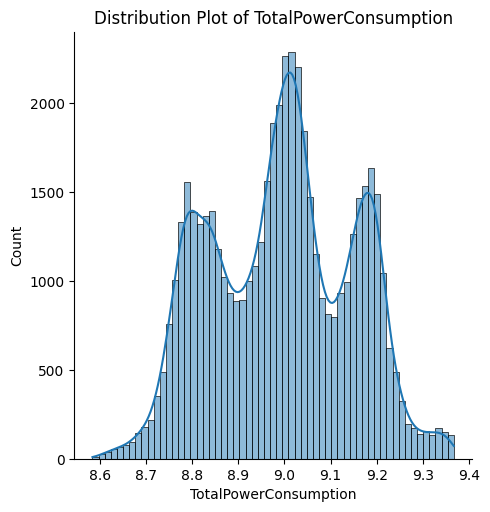

In [51]:
sns.displot(data['TotalPowerConsumption'], kde=True) 
plt.title('Distribution Plot of TotalPowerConsumption')
plt.show()


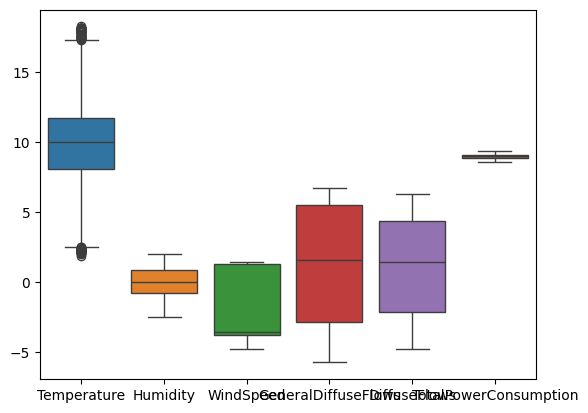

In [52]:
sns.boxplot(data)
plt.show()


In [53]:
x= data.drop(['TotalPowerConsumption'],axis=1)
y=data['TotalPowerConsumption']


## Scaling

In [54]:
Scaler = StandardScaler()


In [55]:
x_scaled = Scaler.fit_transform(x) 


In [56]:
x_scaled


array([[-2.32460743,  0.27732793, -0.78328632, -1.0575885 , -1.01169204],
       [-2.35805137,  0.32903512, -0.78328632, -0.97661612, -1.11990659],
       [-2.38147306,  0.32903512, -0.81477459, -1.00760373, -1.06752738],
       ...,
       [-2.24676709,  0.2042515 , -0.75323729, -0.9301665 , -1.16473634],
       [-2.27904637,  0.21879231, -0.81477459, -0.99163325, -1.10506474],
       [-2.31978123,  0.29943234, -0.80411107, -1.00760373, -1.03400165]])

In [57]:
x_scaled.shape


(52266, 5)

In [58]:
y.shape


(52266,)

In [59]:
x_train,x_test,y_train,y_test= train_test_split(x,y,test_size=0.2,random_state=42)


#### AdFuller Report

In [60]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(y_train)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -205.03155688064086
p-value: 0.0


## ARIMA

In [61]:
import pmdarima as pm
auto_model = pm.auto_arima(y_train, seasonal=False, trace=True,
                            error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=13.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=302339.874, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=1.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=246367.064, Time=3.57 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=11.40 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=199287.976, Time=4.92 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=14.43 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=162719.260, Time=9.37 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=23.20 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=135383.163, Time=23.82 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-37608.630, Time=42.66 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=68.51 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=inf, Time=70.78 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=114097.750, Time=25.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf

In [62]:
auto_model.fit(y_train)


ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)

In [63]:
arima_pred = auto_model.predict(n_periods=len(y_test))


/home/mr-arthor/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/mr-arthor/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [64]:
print(auto_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                41812
Model:                        SARIMAX   Log Likelihood               19525.521
Date:                Sat, 21 Dec 2024   AIC                         -39047.042
Time:                        22:15:04   BIC                         -39029.761
Sample:                             0   HQIC                        -39041.584
                              - 41812                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9922      0.001   1.21e+04      0.000       8.991       8.994
sigma2         0.0230      0.000    112.944      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.31   Jarque-

In [65]:
mse = mean_squared_error(y_test, arima_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.023142634279394666


## SRIMAX

In [66]:
auto_model = pm.auto_arima(y_train,seasonal=True, m=24,trace=True, error_action='ignore',suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-39047.042, Time=9.53 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=227.78 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-39043.387, Time=34.69 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=302339.874, Time=0.53 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=119.38 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=-39045.080, Time=30.66 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=141.76 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-39045.350, Time=14.09 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-39045.347, Time=5.03 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=-39043.351, Time=21.44 sec

Best model:  ARIMA(0,0,0)(0,0,0)[24] intercept
Total fit time: 1061.181 seconds


In [67]:
auto_model.fit(y_train)


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 24),
      suppress_warnings=True)

In [68]:
sarimax_pred = auto_model.predict(n_periods=len(y_test))


/home/mr-arthor/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/mr-arthor/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [69]:
print(auto_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                41812
Model:                        SARIMAX   Log Likelihood               19525.521
Date:                Sat, 21 Dec 2024   AIC                         -39047.042
Time:                        22:32:58   BIC                         -39029.761
Sample:                             0   HQIC                        -39041.584
                              - 41812                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9922      0.001   1.21e+04      0.000       8.991       8.994
sigma2         0.0230      0.000    112.944      0.000       0.023       0.023
Ljung-Box (L1) (Q):                   0.31   Jarque-

In [70]:
mse = mean_squared_error(y_test, sarimax_pred)
print(f'Mean Squared Error (SARIMAX): {mse}')


Mean Squared Error (SARIMAX): 0.023142634279394666


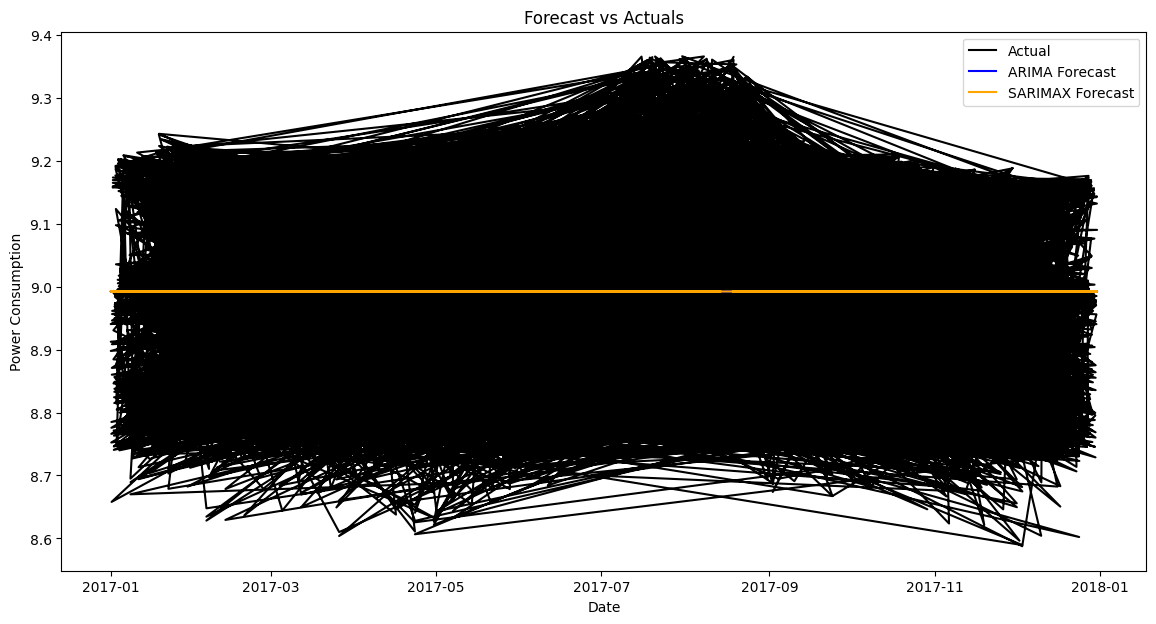

In [71]:
# Plotting results
plt.figure(figsize=(14, 7))
plt.plot(x_test.index, y_test, label='Actual', color='black')  # Actual values
plt.plot(x_test.index, arima_pred, label='ARIMA Forecast', color='blue')  # ARIMA forecast
plt.plot(x_test.index, sarimax_pred, label='SARIMAX Forecast', color='orange')  # SARIMAX forecast
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Power Consumption')
plt.legend()
plt.show()


/tmp/ipykernel_10914/3422623532.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
/home/mr-arthor/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


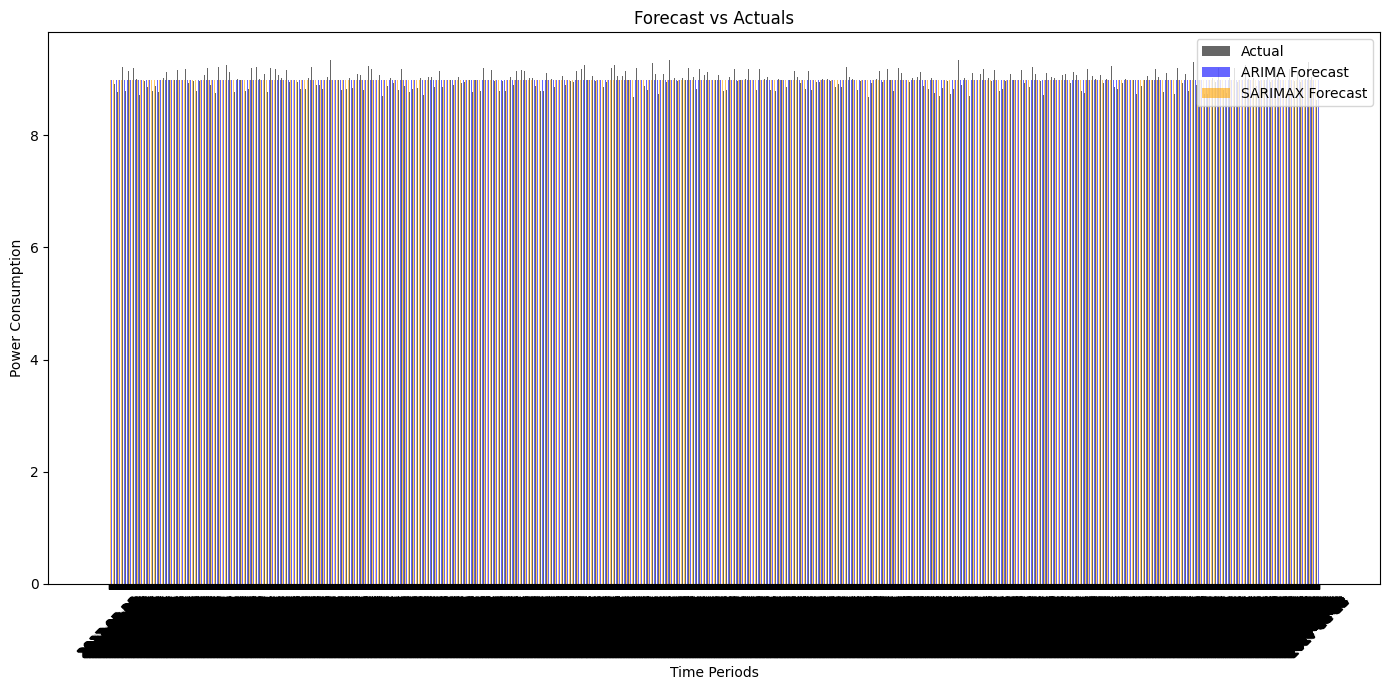

In [72]:
# Prepare the x-axis positions
x_positions = np.arange(len(x_test))

# Create the bar width
bar_width = 0.25

# Plotting results using bar charts
plt.figure(figsize=(14, 7))

# Actual values
plt.bar(x_positions, y_test, width=bar_width, label='Actual', color='black', alpha=0.6)

# ARIMA forecast
plt.bar(x_positions + bar_width, arima_pred, width=bar_width, label='ARIMA Forecast', color='blue', alpha=0.6)

# SARIMAX forecast
plt.bar(x_positions + 2 * bar_width, sarimax_pred, width=bar_width, label='SARIMAX Forecast', color='orange', alpha=0.6)

# Adding titles and labels
plt.title('Forecast vs Actuals')
plt.xlabel('Time Periods')
plt.ylabel('Power Consumption')
plt.xticks(x_positions + bar_width, x_test.index.date, rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()
